Total Device Length: 2300.00 µm
---
Optimal SHG/Total Length Ratio: 0.5026
Optimal SHG Domains: 321
Optimal SFG Domains: 1168
Actual Device Length in Optimal Config: 2300.00 µm
Max Power: 1.745069071585454e-05


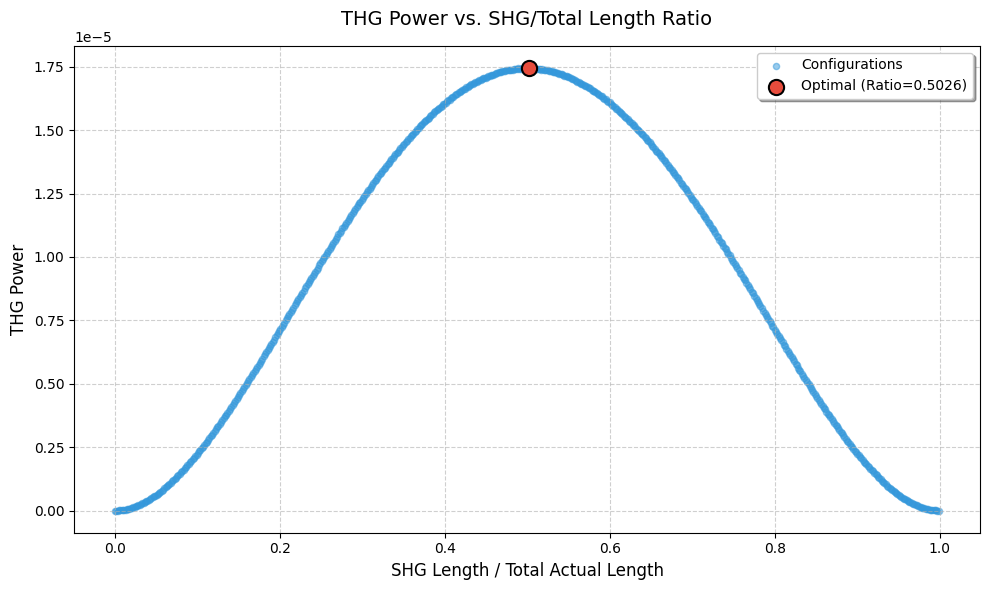

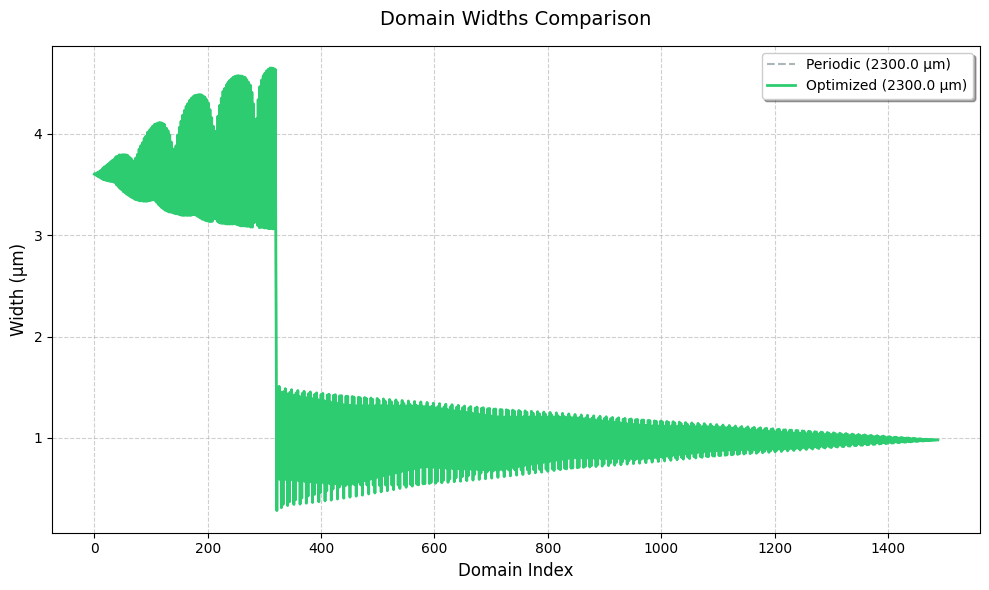

Periodic structure max power / (length)^2: 3.29777651892299e-12
Optimized structure max power / (length)^2: 4.303232729810432e-12


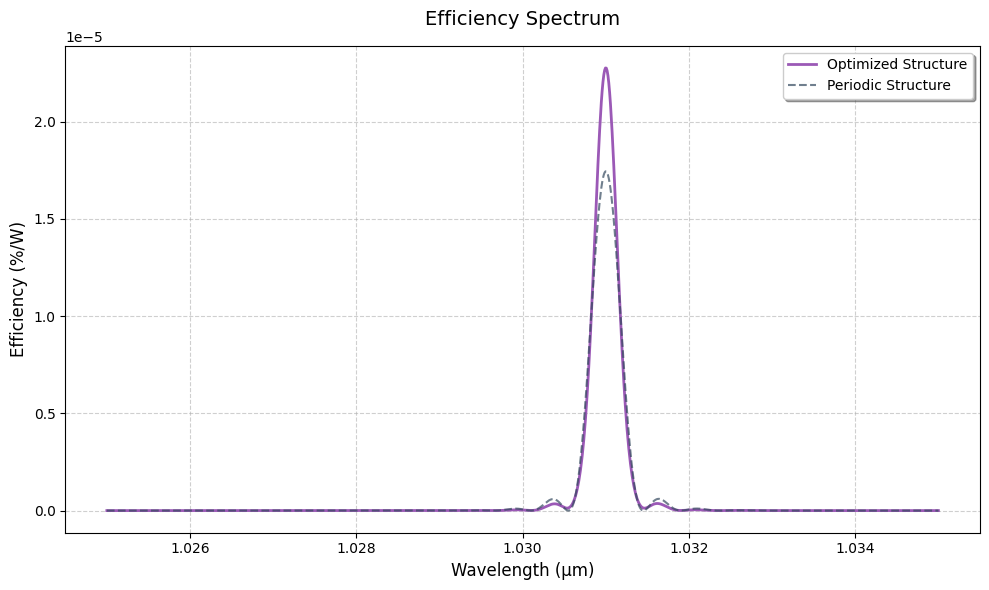

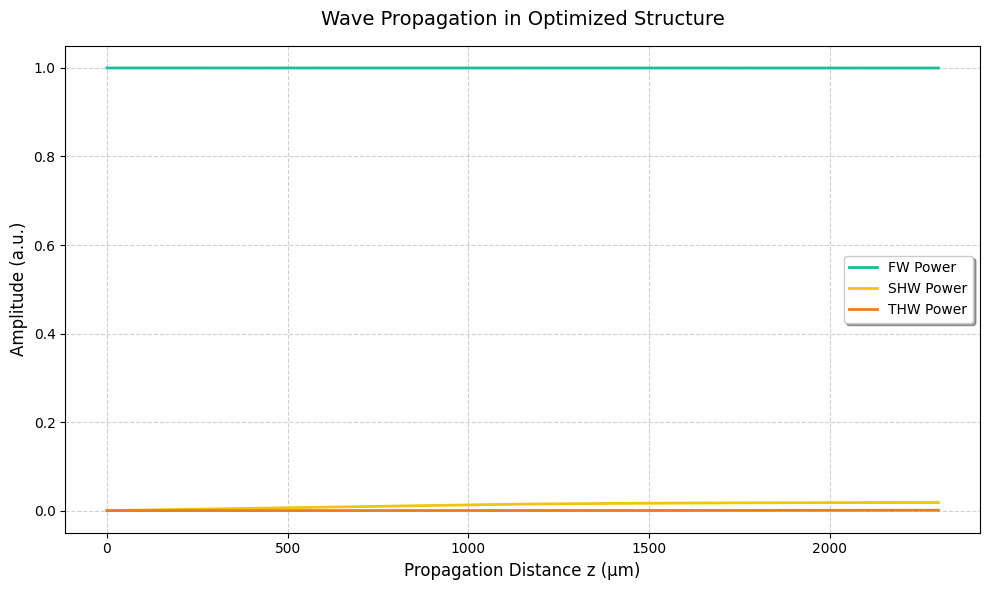

In [4]:
from dataclasses import dataclass, field
from pathlib import Path
from typing import Any

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jit, vmap

from qpm import cwes2, mgoslt

jax.config.update("jax_enable_x64", val=True)

NORO_FACTOR = 100 * 1.07 / 2.84


@dataclass(frozen=True)
class SimulationConfig:
    """Configuration parameters for the THG simulation."""

    total_length: float = 2.3e3  # µm
    design_wl: float = 1.031  # µm
    design_temp: float = 70.0  # °C
    kappa_mag: float = 1.31e-5 / (2 / jnp.pi)
    b_initial: jax.Array = field(default_factory=lambda: jnp.array([1.0, 0.0, 0.0], dtype=jnp.complex128))


def get_phase_mismatches(config: SimulationConfig) -> tuple[float, float]:
    """Calculates phase mismatches at the design wavelength and temperature."""
    delta_k1 = mgoslt.calc_twm_delta_k(config.design_wl, config.design_wl, config.design_temp)
    delta_k2 = mgoslt.calc_twm_delta_k(config.design_wl, config.design_wl / 2, config.design_temp)
    return delta_k1, delta_k2


def build_simulation_inputs(
    total_length: float,
    shg_domain_width: float,
    sfg_domain_width: float,
    max_total_domains: int,
    kappa_mag: float,
) -> tuple[jax.Array, jax.Array, jax.Array, jax.Array]:
    """Generates batched inputs for every valid SHG/SFG domain configuration."""
    # 1. Generate all potential domain counts
    shg_counts = jnp.arange(jnp.floor(total_length / shg_domain_width).astype(jnp.int32) + 1)
    sfg_counts = jnp.floor((total_length - shg_counts * shg_domain_width) / sfg_domain_width).astype(jnp.int32)
    total_counts = shg_counts + sfg_counts

    # 2. Filter for valid configurations where there's at least one domain
    valid_mask = (sfg_counts >= 0) & (total_counts > 0)
    shg_counts, sfg_counts, total_counts = shg_counts[valid_mask], sfg_counts[valid_mask], total_counts[valid_mask]

    # 3. Build batched inputs using vectorized operations
    domain_indices = jnp.arange(max_total_domains)
    is_shg_domain = domain_indices < shg_counts[:, None]
    is_sfg_domain = (domain_indices >= shg_counts[:, None]) & (domain_indices < total_counts[:, None])
    is_active_domain = domain_indices < total_counts[:, None]

    batched_widths = jnp.where(is_shg_domain, shg_domain_width, jnp.where(is_sfg_domain, sfg_domain_width, 0.0))

    base_kappas = kappa_mag * jnp.power(-1, domain_indices)
    batched_kappa_vals = jnp.where(is_active_domain, base_kappas, 0.0)

    return batched_widths, batched_kappa_vals, shg_counts, sfg_counts


def run_discrete_search(config: SimulationConfig) -> dict[str, Any]:
    """Finds the optimal SHG/SFG domain configuration."""
    dk1, dk2 = get_phase_mismatches(config)
    shg_w = jnp.pi / dk1
    sfg_w = jnp.pi / dk2

    max_domains = int(config.total_length / min(shg_w, sfg_w))
    widths, kappas, shg_counts, sfg_counts = build_simulation_inputs(config.total_length, shg_w, sfg_w, max_domains, config.kappa_mag)

    simulate = jit(vmap(cwes2.simulate_twm, in_axes=(0, 0, 0, None, None, None)))
    b_finals = simulate(widths, kappas, kappas, dk1, dk2, config.b_initial)

    thg_powers = jnp.abs(b_finals[:, 2]) ** 2 * NORO_FACTOR
    thg_powers.block_until_ready()

    best_idx = jnp.argmax(thg_powers)

    shg_len = shg_counts[best_idx] * shg_w
    sfg_len = sfg_counts[best_idx] * sfg_w
    actual_len = shg_len + sfg_len

    return {
        "powers": thg_powers,
        "shg_counts": shg_counts,
        "sfg_counts": sfg_counts,
        "shg_w": shg_w,
        "sfg_w": sfg_w,
        "best_idx": best_idx,
        "max_power": thg_powers[best_idx],
        "optimal_ratio": shg_len / actual_len,
        "actual_len": actual_len,
    }


def plot_thg_dependence(search_results: dict[str, Any]) -> None:
    """Plots THG power vs SHG/Total ratio."""
    shg_lens = search_results["shg_counts"] * search_results["shg_w"]
    sfg_lens = search_results["sfg_counts"] * search_results["sfg_w"]
    ratios = shg_lens / (shg_lens + sfg_lens)
    best_idx = search_results["best_idx"]

    plt.figure(figsize=(10, 6))
    plt.scatter(ratios, search_results["powers"], s=20, alpha=0.5, label="Configurations", color="#3498db")
    plt.scatter(
        ratios[best_idx],
        search_results["powers"][best_idx],
        s=120,
        color="#e74c3c",
        edgecolors="black",
        linewidth=1.5,
        label=f"Optimal (Ratio={ratios[best_idx]:.4f})",
        zorder=5,
    )
    plt.title("THG Power vs. SHG/Total Length Ratio", fontsize=14, pad=15)
    plt.xlabel("SHG Length / Total Actual Length", fontsize=12)
    plt.ylabel("THG Power", fontsize=12)
    plt.grid(visible=True, linestyle="--", alpha=0.6)
    plt.legend(frameon=True, shadow=True)
    plt.tight_layout()
    plt.show()


def plot_domain_comparison(optimized_widths: jax.Array, periodic_widths: jax.Array) -> None:
    """Plots domain widths before and after optimization."""
    plt.figure(figsize=(10, 6))
    plt.plot(periodic_widths, label=f"Periodic ({jnp.sum(periodic_widths):.1f} µm)", linestyle="--", color="#95a5a6", alpha=0.8)
    plt.plot(optimized_widths, label=f"Optimized ({jnp.sum(optimized_widths):.1f} µm)", color="#2ecc71", linewidth=2)
    plt.title("Domain Widths Comparison", fontsize=14, pad=15)
    plt.xlabel("Domain Index", fontsize=12)
    plt.ylabel("Width (μm)", fontsize=12)
    plt.grid(visible=True, linestyle="--", alpha=0.6)
    plt.legend(frameon=True, shadow=True)
    plt.tight_layout()
    plt.show()


def run_spectrum_simulation(config: SimulationConfig, widths: jax.Array, wls: jax.Array) -> jax.Array:
    """Calculates efficiency spectrum for a given structure."""
    dk1s = mgoslt.calc_twm_delta_k(wls, wls, config.design_temp)
    dk2s = mgoslt.calc_twm_delta_k(wls, wls / 2, config.design_temp)

    kappa_vals = config.kappa_mag * jnp.power(-1, jnp.arange(widths.shape[0]))
    batch_simulate = jit(vmap(cwes2.simulate_twm, in_axes=(None, None, None, 0, 0, None)))
    b_finals = batch_simulate(widths, kappa_vals, kappa_vals, dk1s, dk2s, config.b_initial)

    return jnp.abs(b_finals[:, 2]) ** 2 * NORO_FACTOR


def plot_efficiency_spectrum(wls: jax.Array, optimized_powers: jax.Array, periodic_powers: jax.Array) -> None:
    """Plots the efficiency spectrum."""
    plt.figure(figsize=(10, 6))
    plt.plot(wls, optimized_powers, label="Optimized Structure", color="#9b59b6", linewidth=2)
    plt.plot(wls, periodic_powers, label="Periodic Structure", color="#34495e", linestyle="--", alpha=0.7)
    plt.title("Efficiency Spectrum", fontsize=14, pad=15)
    plt.xlabel("Wavelength (μm)", fontsize=12)
    plt.ylabel("Efficiency (%/W)", fontsize=12)
    plt.grid(visible=True, linestyle="--", alpha=0.6)
    plt.legend(frameon=True, shadow=True)
    plt.tight_layout()
    plt.show()


def plot_propagation_trace(config: SimulationConfig, optimized_widths: jax.Array) -> None:
    """Calculates and plots wave propagation trace."""
    dk1, dk2 = get_phase_mismatches(config)
    kappa_vals = config.kappa_mag * jnp.power(-1, jnp.arange(optimized_widths.shape[0]))

    _, full_trace = cwes2.simulate_twm_with_trace(optimized_widths, kappa_vals, kappa_vals, jnp.array(dk1), jnp.array(dk2), config.b_initial)

    z = jnp.concatenate([jnp.array([0.0]), jnp.cumsum(optimized_widths)])
    fw_amp = jnp.abs(full_trace[:, 0])
    shw_amp = jnp.abs(full_trace[:, 1])
    thw_amp = jnp.abs(full_trace[:, 2])

    plt.figure(figsize=(10, 6))
    plt.plot(z, fw_amp, label="FW Power", color="#1abc9c", linewidth=2)
    plt.plot(z, shw_amp, label="SHW Power", color="#f1c40f", linewidth=2)
    plt.plot(z, thw_amp, label="THW Power", color="#e67e22", linewidth=2)
    plt.title("Wave Propagation in Optimized Structure", fontsize=14, pad=15)
    plt.xlabel("Propagation Distance z (μm)", fontsize=12)
    plt.ylabel("Amplitude (a.u.)", fontsize=12)
    plt.grid(visible=True, linestyle="--", alpha=0.6)
    plt.legend(frameon=True, shadow=True)
    plt.tight_layout()
    plt.show()


def main() -> None:
    """Main execution block."""
    config = SimulationConfig()

    # 1. Discrete search
    print(f"Total Device Length: {config.total_length:.2f} µm")
    search_res = run_discrete_search(config)
    print("---")
    print(f"Optimal SHG/Total Length Ratio: {search_res['optimal_ratio']:.4f}")
    print(f"Optimal SHG Domains: {search_res['shg_counts'][search_res['best_idx']]}")
    print(f"Optimal SFG Domains: {search_res['sfg_counts'][search_res['best_idx']]}")
    print(f"Actual Device Length in Optimal Config: {search_res['actual_len']:.2f} µm")
    print(f"Max Power: {search_res['max_power']}")

    plot_thg_dependence(search_res)

    # 2. Compare structures
    opt_num_shg = int(search_res["shg_counts"][search_res["best_idx"]])
    opt_num_sfg = int(search_res["sfg_counts"][search_res["best_idx"]])
    periodic_widths = jnp.concatenate([jnp.full(opt_num_shg, search_res["shg_w"]), jnp.full(opt_num_sfg, search_res["sfg_w"])])
    dataset_path = Path("../../datasets") / "optimized_thg_2000_1489_e4.npy"
    optimized_widths = jnp.load(dataset_path)

    plot_domain_comparison(optimized_widths, periodic_widths)

    # 3. Efficiency spectrum
    wls = jnp.linspace(1.025, 1.035, 1000)
    pow_periodic = run_spectrum_simulation(config, periodic_widths, wls)
    pow_optimized = run_spectrum_simulation(config, optimized_widths, wls)

    periodic_len = jnp.sum(periodic_widths)
    optimized_len = jnp.sum(optimized_widths)
    print(f"Periodic structure max power / (length)^2: {jnp.max(pow_periodic) / periodic_len**2}")
    print(f"Optimized structure max power / (length)^2: {jnp.max(pow_optimized) / optimized_len**2}")

    plot_efficiency_spectrum(wls, pow_optimized, pow_periodic)

    # 4. Propagation trace
    plot_propagation_trace(config, optimized_widths)


if __name__ == "__main__":
    main()
